# Radiocarbon with OCIM

A simple model for $R \equiv \frac{^{14}\mathrm{C}}{^{12}\mathrm{C}}$ normalized so that $R=1$ in the atmosphere.

$$\frac{\partial R}{\partial t} + [\mathbf{TRdiv}]R = \kappa\boldsymbol{\Lambda}(1-R) -\lambda R$$

Here we will redo the radiocarbon age example, but using the OCIM1 transport operator made available through the AIBECS package

In [1]:
using AIBECS
mask, grd, T_OCIM = OCIM1.load() ;

Loading OCIM1┌ Warning: Over-writing registration of the datadep
│   name = AIBECS_OCIM1
└ @ DataDeps /home/travis/.julia/packages/DataDeps/LiEdA/src/registration.jl:8
 ✔

You are about to use the OCIM1, for which the references to cite are:

- DeVries, T., 2014: The oceanic anthropogenic CO2 sink: Storage, air‐sea fluxes, and transports over the industrial era, Global Biogeochem. Cycles, 28, 631–647, doi:10.1002/2013GB004739.

- DeVries, T. and F. Primeau, 2011: Dynamically and Observationally Constrained Estimates of Water-Mass Distributions and Ages in the Global Ocean. J. Phys. Oceanogr., 41, 2381–2401, https://doi.org/10.1175/JPO-D-10-05011.1

You can find the corresponding BibTeX entries in the CITATION.bib file at the root of the AIBECS.jl package repository, with the keys "DeVries_Primeau_2011" and "DeVries_2014".




Some useful OCIM stuff

In [2]:
iwet = findall(vec(mask))       # index to wet grdboxes
h = ustrip(grd.δdepth[1])     # thickness of the top layer
z = ustrip.(grd.depth_3D[iwet]) # depth of the grdbox centers
nwet = length(iwet)             # number of wet grd boxes
v = vector_of_volumes(mask,grd)# volume of the grdboxes
lat, lon = ustrip.(grd.lat), ustrip.(grd.lon) # latitudes and longitudes (useful for plotting)
depth = ustrip.(grd.depth) ;

Make a table of parameters

In [3]:
t = empty_parameter_table()               # initialize table of parameters
add_parameter!(t, :λ, 1 / (5730*log(2))u"yr") # add the radioactive decay e-folding timescale
add_parameter!(t, :κ, 50u"m" / 10u"yr")
add_parameter!(t, :z₀, 20u"m")
initialize_Parameters_type(t, "C14_Parameters") # Generate the parameter table

The model parameters

In [4]:
p = C14_Parameters()

     λ = 2.52e-04 [yr⁻¹] (fixed)
     κ = 5.00e+00 [m yr⁻¹] (fixed)
    z₀ = 2.00e+01 [m] (fixed)


The sources and sinks of $R$

In [5]:
function sms(R, p)
    λ, κ, z₀ = p.λ, p.κ, p.z₀
    return κ / h * (z .< z₀) .* (1.0 .- R) - λ * R
end

sms (generic function with 1 method)

The tracer transport operator

In [6]:
T_14c(p) = T_OCIM

T_14c (generic function with 1 method)

Prepare the stuff needed for the AIBECS solver:

In [7]:
T_matrices = (T_14c,)            # bundles all the transport matrices in a tuple
sources_minus_sinks = (sms,) # bundles all the source-sink functions in a tuple
F, ∇ₓF = state_function_and_Jacobian(T_matrices, sources_minus_sinks, nwet) # generates the state function (and its Jacobian!)

(getfield(AIBECS, Symbol("#F#19")){getfield(AIBECS, Symbol("#T#15")){Tuple{typeof(Main.##367.T_14c)}},getfield(AIBECS, Symbol("#G#17")){Tuple{typeof(Main.##367.sms)},getfield(AIBECS, Symbol("#tracers#14")){Int64,Int64}}}(getfield(AIBECS, Symbol("#T#15")){Tuple{typeof(Main.##367.T_14c)}}((Main.##367.T_14c,)), getfield(AIBECS, Symbol("#G#17")){Tuple{typeof(Main.##367.sms)},getfield(AIBECS, Symbol("#tracers#14")){Int64,Int64}}((Main.##367.sms,), getfield(AIBECS, Symbol("#tracers#14")){Int64,Int64}(200160, 1))), getfield(AIBECS, Symbol("#∇ₓF#21")){getfield(AIBECS, Symbol("#T#15")){Tuple{typeof(Main.##367.T_14c)}},getfield(AIBECS, Symbol("#∇ₓG#20")){Tuple{typeof(Main.##367.sms)},Int64,Int64}}(getfield(AIBECS, Symbol("#T#15")){Tuple{typeof(Main.##367.T_14c)}}((Main.##367.T_14c,)), getfield(AIBECS, Symbol("#∇ₓG#20")){Tuple{typeof(Main.##367.sms)},Int64,Int64}((Main.##367.sms,), 200160, 1)))

In [8]:
x = ones(nwet)                           # initial iterate for the solver
prob = SteadyStateProblem(F, ∇ₓF, x, p) # define the problem
R = solve(prob, CTKAlg())                 # solve the problem
c14age = -log.(R) / p.λ ;                   # convert R to $^{14}C-age$

Make some plots

In [9]:
c14age_3d = fill(NaN, size(mask))     # creates a 3D array of NaNs
c14age_3d[iwet] = c14age   # Fills the wet grd boxes with the age values
size(c14age_3d)            # Just to check the size of age_3D

(91, 180, 24)

Pick a layer to plot

In [10]:
iz = findfirst(depth .> 700) # aim for a depth of ~ 700 m
depth_map = Int(round(depth[iz]))
iz, depth_map
c14age_3d_1000m_yr = c14age_3d[:,:,iz] * ustrip(1.0u"s" |> u"yr")

91×180 Array{Float64,2}:
  NaN      NaN      NaN      NaN      …  NaN      NaN      NaN       NaN    
  NaN      NaN      NaN      NaN         NaN      NaN      NaN       NaN    
  NaN      NaN      NaN      NaN         NaN      NaN      NaN       NaN    
  NaN      NaN      NaN      NaN         NaN      NaN      NaN       NaN    
  NaN      NaN      NaN      NaN         NaN      NaN      NaN       NaN    
  NaN      NaN      NaN      NaN      …  NaN      NaN      NaN       NaN    
  NaN      NaN      NaN      NaN         NaN      NaN      NaN       NaN    
  NaN      NaN      NaN      NaN         NaN      NaN      NaN       NaN    
  NaN      NaN      NaN      NaN         NaN      NaN      NaN       NaN    
 1342.82   NaN      NaN      NaN         NaN      NaN      NaN      1342.79 
    ⋮                                 ⋱                                     
  551.565  551.434  552.414  553.257     552.514  551.17   551.323   552.009
  548.607  550.837  552.478  553.964     545.618  5

In [11]:
ENV["MPLBACKEND"]="qt5agg"
using PyPlot, PyCall

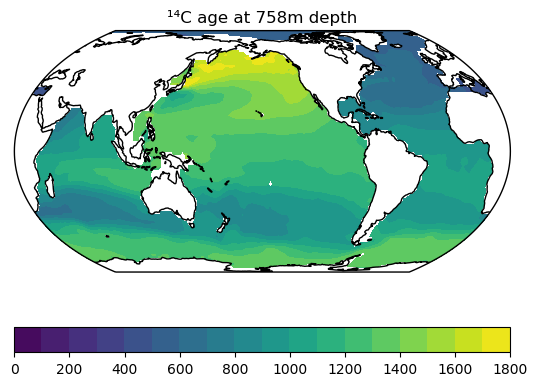

In [12]:
clf()
ccrs = pyimport("cartopy.crs")
ax = subplot(projection=ccrs.EqualEarth(central_longitude=-155.0))
ax.coastlines()
lon_cyc = [lon; 360+lon[1]] # making it cyclic for Cartopy
age_cyc = hcat(c14age_3d_1000m_yr, c14age_3d_1000m_yr[:,1])
p = contourf(lon_cyc, lat, age_cyc, levels=0:100:1800, transform=ccrs.PlateCarree(), zorder=-1)
colorbar(p, orientation="horizontal")
title("¹⁴C age at $(depth_map)m depth")
gcf() # gets the current figure to display

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*